In [1]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.227 🚀 Python-3.10.9 torch-2.2.2 CPU (Intel Core(TM) i7-4770HQ 2.20GHz)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 211.7/931.6 GB disk)


In [10]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
import shutil
import tqdm
import glob

In [12]:
from tqdm import tqdm


In [6]:
import os
import shutil
import random
import glob
from tqdm import tqdm  # Make sure tqdm is installed

# Define paths
base_path = '/Users/macbook/Downloads/YoloV8/dataset'
images_path = os.path.join(base_path, 'images')
labels_path = os.path.join(base_path, 'labels')

# Create necessary directories for train and valid splits
os.makedirs(os.path.join(base_path, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'valid', 'images'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'valid', 'labels'), exist_ok=True)

# List all image files
image_files = glob.glob(os.path.join(images_path, '*.PNG'))
image_files += glob.glob(os.path.join(images_path, '*.png'))

# Print debug information
print(f"Found {len(image_files)} image files.")

# Shuffle the list of files
random.shuffle(image_files)

# Define split ratio (e.g., 80% training, 20% validation)
split_ratio = 0.8
split_index = int(len(image_files) * split_ratio)

train_files = image_files[:split_index]
valid_files = image_files[split_index:]

# Print debug information for splits
print(f"Train files: {len(train_files)}")
print(f"Valid files: {len(valid_files)}")


Found 245 image files.
Train files: 196
Valid files: 49


In [14]:
# Function to copy files
def copy_files(files, dest_images, dest_labels):
    for file in tqdm(files):
        file_name = os.path.basename(file)
        base_name = os.path.splitext(file_name)[0]

        # Copy image file
        shutil.copyfile(file, os.path.join(dest_images, file_name))

        # Copy corresponding label file
        label_file = os.path.join(labels_path, base_name + '.txt')
        if os.path.exists(label_file):
            shutil.copyfile(label_file, os.path.join(dest_labels, base_name + '.txt'))
        else:
            print(f"Warning: Label file {label_file} does not exist.")

# Copy training files
print('Copying Train Data..!!')
copy_files(
    train_files,
    os.path.join(base_path, 'train', 'images'),
    os.path.join(base_path, 'train', 'labels')
)

# Copy validation files
print('Copying Valid Data..!!')
copy_files(
    valid_files,
    os.path.join(base_path, 'valid', 'images'),
    os.path.join(base_path, 'valid', 'labels')
)


Copying Train Data..!!


 16%|██████▋                                  | 32/196 [00:00<00:00, 316.76it/s]

100%|████████████████████████████████████████| 196/196 [00:00<00:00, 365.86it/s]


Copying Valid Data..!!


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 360.60it/s]


In [15]:
import pandas as pd
from collections import Counter

# Initialize an empty DataFrame for labels
labels_df = pd.DataFrame()

# Define splits and label directories
splits = ["train", "valid"]
label_files = []
for split in splits:
    label_path = os.path.join(base_path, split, 'labels')
    if os.path.exists(label_path):
        label_files.extend([os.path.join(label_path, f) for f in os.listdir(label_path) if f.endswith('.txt')])
    else:
        print(f"Warning: Directory '{label_path}' does not exist or is empty.")

# Count annotations and update DataFrame
for label_file in label_files:
    lbl_counter = Counter()
    with open(label_file, 'r') as lf:
        lines = lf.readlines()
    for line in lines:
        class_id = int(line.split()[0])
        lbl_counter[class_id] += 1

    for class_id, count in lbl_counter.items():
        labels_df.loc[os.path.splitext(os.path.basename(label_file))[0], class_id] = count

labels_df = labels_df.fillna(0.0)

print(labels_df)


                                2    0    1
Screenshot 2025-04-14 151400  4.0  1.0  1.0
Screenshot 2025-04-17 021704  0.0  0.0  1.0
Screenshot 2025-04-14 145717  2.0  0.0  1.0
Screenshot 2025-04-14 153439  2.0  1.0  1.0
Screenshot 2025-04-14 150656  2.0  0.0  1.0
...                           ...  ...  ...
Screenshot 2025-04-17 021907  0.0  0.0  1.0
Screenshot 2025-04-14 155044  0.0  1.0  0.0
Screenshot 2025-04-17 021912  0.0  0.0  1.0
Screenshot 2025-04-17 021709  0.0  0.0  1.0
Screenshot 2025-04-14 155333  0.0  1.0  0.0

[243 rows x 3 columns]


In [16]:
import yaml

# Define paths and class names for YOLOv8
yaml_data = {
    'path': '/Users/macbook/Downloads/YoloV8/dataset',
    'train': 'train/images',
    'val': 'valid/images',
    'names': ['Ball', 'Goal', 'Player']
}

yaml_filename = os.path.join('/Users/macbook/Downloads/YoloV8/dataset', 'data.yaml')

with open(yaml_filename, 'w') as yaml_file:
    yaml.dump(yaml_data, yaml_file)

# Verify YAML file content
with open(yaml_filename, 'r', encoding="utf8") as y:
    classes = yaml.safe_load(y)['names']

print(list(zip(classes, range(len(classes)))))


[('Ball', 0), ('Goal', 1), ('Player', 2)]


In [ ]:
# Path to the best model
best_model_path = 'best.pt'

# Load the trained model
best_model = YOLO(best_model_path)

In [17]:
from ultralytics import YOLO

# Initialize a YOLOv8 model
model = YOLO('yolov8n.pt')  # You can choose another YOLOv8 model variant like yolov8s.pt, yolov8m.pt, etc.

# Train the model and specify project and experiment name
results = model.train(
    data='/Users/macbook/Downloads/YoloV8/dataset/data.yaml',
    epochs=5,
    imgsz=640,
    project='/Users/macbook/Downloads/YoloV8/results',  # Specify the project directory
    name='exp1'  # Specify the experiment name
)


100%|██████████████████████████████████████| 6.23M/6.23M [00:01<00:00, 3.54MB/s]


New https://pypi.org/project/ultralytics/8.3.111 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.227 🚀 Python-3.10.9 torch-2.2.2 CPU (Intel Core(TM) i7-4770HQ 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/macbook/Downloads/YoloV8/dataset/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/Users/macbook/Downloads/YoloV8/results, name=exp1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, 

train: Scanning /Users/macbook/Downloads/YoloV8/dataset/train/labels... 194 imag

train: New cache created: /Users/macbook/Downloads/YoloV8/dataset/train/labels.cache



val: Scanning /Users/macbook/Downloads/YoloV8/dataset/valid/labels... 49 images,


val: New cache created: /Users/macbook/Downloads/YoloV8/dataset/valid/labels.cache
Plotting labels to /Users/macbook/Downloads/YoloV8/results/exp1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/macbook/Downloads/YoloV8/results/exp1
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.903      3.258      1.721         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         49        102     0.0066      0.761      0.444      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.814      2.157       1.61         18        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         49        102      0.204      0.628       0.45      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.719       2.03      1.549          5        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         49        102      0.927      0.551      0.676      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.633      1.771        1.5         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         49        102          1       0.37      0.688      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.589      1.568      1.454         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         49        102       0.99      0.519      0.762      0.348



5 epochs completed in 0.125 hours.
Optimizer stripped from /Users/macbook/Downloads/YoloV8/results/exp1/weights/last.pt, 6.2MB
Optimizer stripped from /Users/macbook/Downloads/YoloV8/results/exp1/weights/best.pt, 6.2MB

Validating /Users/macbook/Downloads/YoloV8/results/exp1/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.9 torch-2.2.2 CPU (Intel Core(TM) i7-4770HQ 2.20GHz)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         49        102       0.99      0.519      0.762      0.348
                  Ball         49         23          1      0.385      0.549      0.192
                  Goal         49         33       0.97       0.98      0.977      0.533
                Player         49         46          1      0.191      0.761      0.319
Speed: 3.6ms preprocess, 122.5ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /Users/macbook/Downloads/YoloV8/results/exp1


In [18]:
# Path to the best model
best_model_path = '/Users/macbook/Downloads/YoloV8/results/exp1/weights/best.pt'

# Load the trained model
best_model = YOLO(best_model_path)



image 1/1 /Users/macbook/Downloads/test2.png: 320x640 (no detections), 86.8ms
Speed: 2.1ms preprocess, 86.8ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


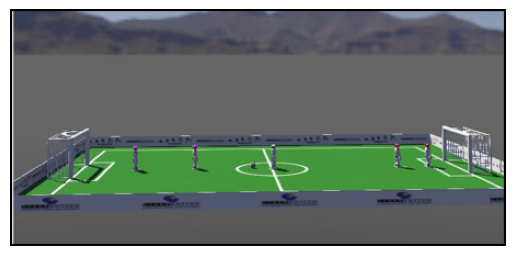

In [24]:
# Path to the image for prediction
image_path = "/Users/macbook/Downloads/test2.png"  # Replace with the path to your image

# Make predictions
results = best_model.predict(image_path)

# Visualize predictions using OpenCV
for result in results:
    # Load the image
    image = cv2.imread(image_path)

    # Get bounding boxes, classes, and confidences
    boxes = result.boxes.xyxy.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy().astype(int)
    confidences = result.boxes.conf.cpu().numpy()

    for box, cls, conf in zip(boxes, classes, confidences):
        # Draw the bounding box
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Put the class label and confidence on the image
        label = f"{best_model.names[cls]}: {conf:.2f}"
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Display the image with predictions
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

Contents of the directory: ['confusion_matrix.png', 'val_batch1_labels.jpg', 'events.out.tfevents.1745042432.Macbooks-MacBook-Pro.local.24836.0', 'args.yaml', 'results.png', 'P_curve.png', 'weights', 'labels_correlogram.jpg', 'val_batch0_labels.jpg', 'F1_curve.png', 'train_batch0.jpg', 'train_batch1.jpg', 'confusion_matrix_normalized.png', 'train_batch2.jpg', 'val_batch1_pred.jpg', 'val_batch0_pred.jpg', 'R_curve.png', 'labels.jpg', 'results.csv', 'PR_curve.png']


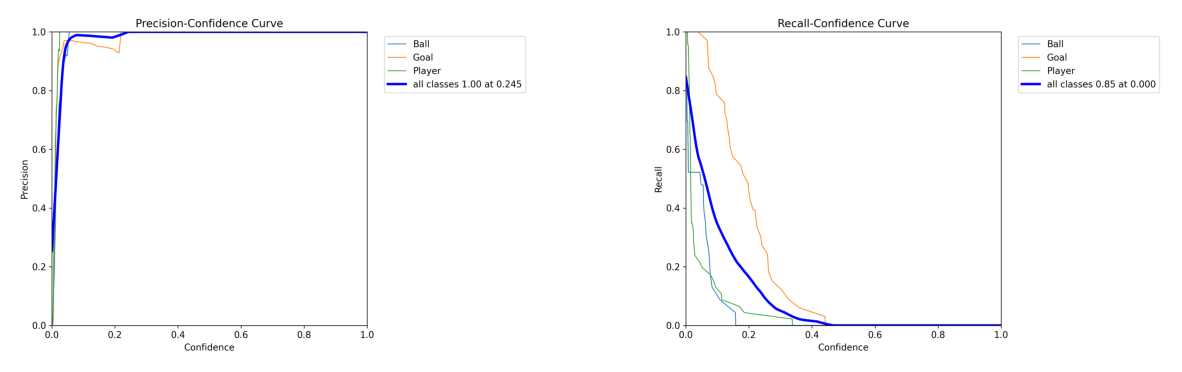

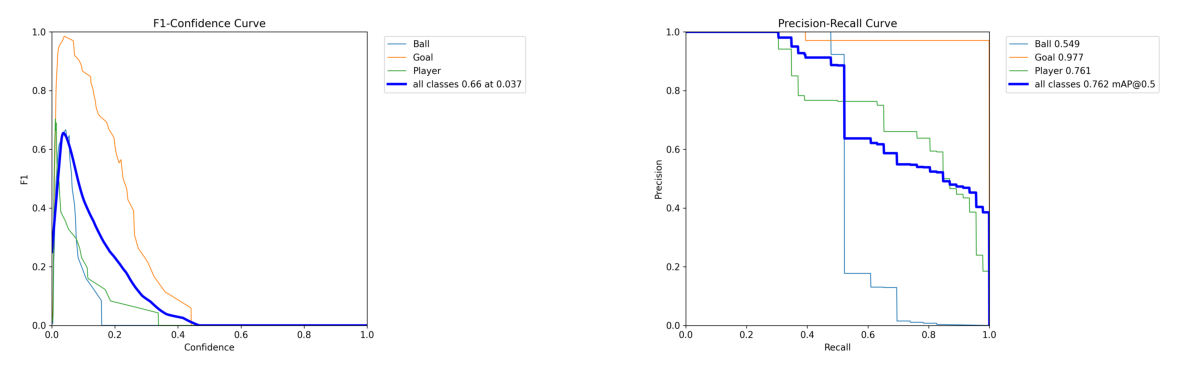

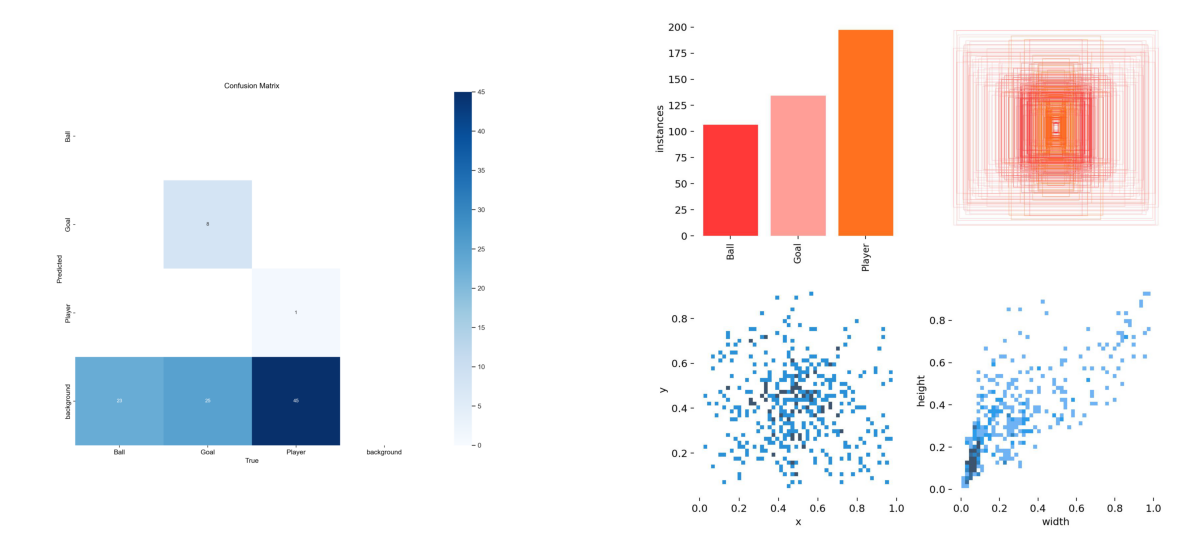

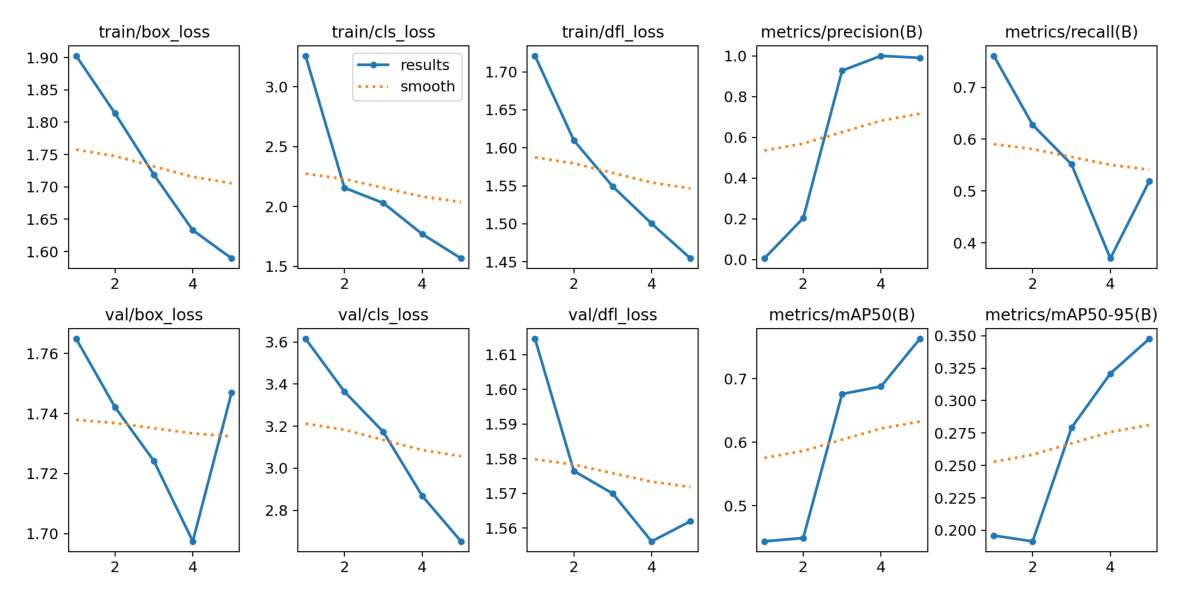

In [25]:
import os
import matplotlib.pyplot as plt

# Specify the path to the folder where the training results are saved
model_path = '/Users/macbook/Downloads/YoloV8/results/exp1/'

# Print the contents of the model_path directory to verify files
print("Contents of the directory:", os.listdir(model_path))

# Define a function to plot images
def plot(image_list, size):
    c = 1
    plt.figure(figsize=(15, 10))
    for image_name in image_list:
        full_path = model_path + image_name
        if os.path.exists(full_path):
            image = plt.imread(full_path)
            plt.subplot(size[0], size[1], c)
            plt.imshow(image)
            plt.axis('off')  # Hide the axis
            c += 1
        else:
            print(f"File not found: {full_path}")
    plt.show()

# Plot the specified images
plot(['P_curve.png', 'R_curve.png'], (1, 2))
plot(['F1_curve.png', 'PR_curve.png'], (1, 2))
plot(['confusion_matrix.png', 'labels.jpg'], (1, 2))
plot(['results.png'], (1, 1))
